In [156]:
import sys
sys.path.append('C:/Users/hoang/PycharmProjects/ReeMo_mini')

In [157]:
import winning_model.utils as utils
import constant
from collections import defaultdict

In [158]:
coln = [utils.get_coln(n) for n in ['slot_id', 'bid_price', 'is_rt_any', 'label']]
features_coln = [utils.get_coln(n) for n in ['slot_id', 'bid_price', 'label']]
dic_rtg = {'not_rtg': 0, 'is_rtg': 1, 'all_rtg': -1}
kwargs = {
    'max_depth': 5,
    'num_tree': 40,
    'test_size': -1,
    'seed':0
}
training_file = constant.get_winning_features_file()
dics_winning_model = defaultdict(dict)
dics_pct_prices = defaultdict(dict)
dics_real_data = defaultdict(dict)
dics_results = defaultdict(dict)

In [159]:
dics_winning_model

defaultdict(dict, {})

In [160]:
from pyspark.sql import SparkSession
import winning_model.support_function as support_function
import winning_model.preprocess_function as preprocess_function
import winning_model.training_function as training_function
from pyspark.sql.functions import col

In [161]:
spark = SparkSession.builder.appName('train_winning_model') \
        .config('spark.kryoserializer.buffer.max', '1g').getOrCreate()
df = preprocess_function.preproc(spark, training_file).select(coln) # DFD lv1 -> Need break more
df.show()

+-------+---------+---------+---------+
|slot_id|bid_price|is_rt_any|is_winner|
+-------+---------+---------+---------+
|  36388|    252.2|        0|        1|
|  36388|      9.9|        0|        0|
|  33952|   6570.7|        0|        1|
|  33952|      1.0|        0|        0|
|  37834|     82.0|        1|        1|
|  37834|      3.0|        1|        0|
|  37713|      1.2|        1|        1|
|  36318|     67.3|        1|        1|
|  36318|      2.7|        1|        0|
|  17549|    249.3|        1|        1|
|  38515|     83.5|        0|        1|
|  37713|      2.7|        1|        1|
|  37713|      1.6|        1|        1|
|  36506|    168.3|        1|        1|
|  38507|    508.5|        1|        1|
|  38507|     11.0|        1|        0|
|  34094|    233.6|        0|        1|
|  37677|    133.6|        1|        1|
|  37677|      0.1|        1|        0|
|  34884|      2.5|        1|        1|
+-------+---------+---------+---------+
only showing top 20 rows



In [162]:
features_coln

['slot_id', 'bid_price', 'is_winner']

In [416]:
df_rtg = df.select(features_coln).filter(col(utils.get_coln('is_rt_any')) == 1).cache()
df_rtg.show()

+-------+---------+---------+
|slot_id|bid_price|is_winner|
+-------+---------+---------+
|  37834|     82.0|        1|
|  37834|      3.0|        0|
|  37713|      1.2|        1|
|  36318|     67.3|        1|
|  36318|      2.7|        0|
|  17549|    249.3|        1|
|  37713|      2.7|        1|
|  37713|      1.6|        1|
|  36506|    168.3|        1|
|  38507|    508.5|        1|
|  38507|     11.0|        0|
|  37677|    133.6|        1|
|  37677|      0.1|        0|
|  34884|      2.5|        1|
|  34880|     65.0|        1|
|  34880|      6.4|        0|
|  32621|    126.2|        1|
|  38378|     56.8|        1|
|  38378|      0.0|        0|
|  29210|     11.5|        1|
+-------+---------+---------+
only showing top 20 rows



In [417]:
list_slot_ids_not_modeled = []
split_slot_ids = support_function.calc_split_slot_ids(df_rtg)

In [422]:
slot_cnts = df_rtg.groupBy('slot_id').count().collect()
slot_cnts = np.asarray(slot_cnts)
slot_cnts

array([[37146,     7],
       [12799,     4],
       [10914,    25],
       [35950,    83],
       [38139,     2],
       [37175,    34],
       [37713,   265],
       [37389,   235],
       [22713,     5],
       [36733,     3],
       [22382,    43],
       [38622,    38],
       [28057,     1],
       [34432,     1],
       [23295,    13],
       [35214,    56],
       [38128,   105],
       [38431,    17],
       [32762,    13],
       [37965,    17],
       [26945,     6],
       [27140,     3],
       [11234,     1],
       [32621,    20],
       [38315,     2],
       [34263,    18],
       [37794,     5],
       [38507,    74],
       [17549,   169],
       [19024,    21],
       [28806,     3],
       [38142,     2],
       [38127,    73],
       [22442,    81],
       [38147,    19],
       [35709,    42],
       [38089,     3],
       [37893,     6],
       [28180,    24],
       [35236,    10],
       [28332,    81],
       [38409,    15],
       [27302,     6],
       [379

In [165]:
split_slot_ids

[[37146,
  12799,
  10914,
  35950,
  38139,
  37175,
  37713,
  37389,
  22713,
  36733,
  22382,
  38622,
  28057,
  34432,
  23295,
  35214,
  38128,
  38431,
  32762,
  37965,
  26945,
  27140,
  11234,
  32621,
  38315,
  34263,
  37794,
  38507,
  17549,
  19024,
  28806,
  38142,
  38127,
  22442,
  38147,
  35709,
  38089,
  37893,
  28180,
  35236,
  28332,
  38409,
  27302,
  37946,
  37485,
  23545,
  36318,
  28670,
  37861,
  36734,
  27834,
  34148,
  33545,
  29362,
  23606,
  30036,
  34772,
  18315,
  36825,
  36260,
  37083,
  37896,
  33140,
  31063,
  34217,
  29917,
  35886,
  22341,
  16756,
  31538,
  28566,
  29451,
  30542,
  24774,
  33093,
  29751,
  26407,
  34368,
  29912,
  21708,
  21094,
  38329,
  38000,
  37414,
  27630,
  23039,
  37003,
  37619,
  29578,
  18326,
  37509,
  30935,
  37428,
  38197,
  38281,
  32421,
  37151,
  37511,
  37492,
  37899,
  30728,
  19300,
  38313,
  36833,
  28669,
  29136,
  38057,
  29643,
  38446,
  11358,
  20980,
 

In [166]:
n_step = len(split_slot_ids)
n_slot_ids = len([slot_id for each_ids in split_slot_ids
                      for slot_id in each_ids])
print("There are %d slots. Let's fit these data!" % n_slot_ids)
print(n_step)

There are 324 slots. Let's fit these data!
1


In [167]:
[{i: slot_ids} for i, slot_ids in enumerate(split_slot_ids, 1)]

[{1: [37146,
   12799,
   10914,
   35950,
   38139,
   37175,
   37713,
   37389,
   22713,
   36733,
   22382,
   38622,
   28057,
   34432,
   23295,
   35214,
   38128,
   38431,
   32762,
   37965,
   26945,
   27140,
   11234,
   32621,
   38315,
   34263,
   37794,
   38507,
   17549,
   19024,
   28806,
   38142,
   38127,
   22442,
   38147,
   35709,
   38089,
   37893,
   28180,
   35236,
   28332,
   38409,
   27302,
   37946,
   37485,
   23545,
   36318,
   28670,
   37861,
   36734,
   27834,
   34148,
   33545,
   29362,
   23606,
   30036,
   34772,
   18315,
   36825,
   36260,
   37083,
   37896,
   33140,
   31063,
   34217,
   29917,
   35886,
   22341,
   16756,
   31538,
   28566,
   29451,
   30542,
   24774,
   33093,
   29751,
   26407,
   34368,
   29912,
   21708,
   21094,
   38329,
   38000,
   37414,
   27630,
   23039,
   37003,
   37619,
   29578,
   18326,
   37509,
   30935,
   37428,
   38197,
   38281,
   32421,
   37151,
   37511,
   37492,
   3789

In [168]:
slot_ids_each = split_slot_ids[0]
# slots_rdd = spark.sparkContext.parallelize(slot_ids_each)\
#             .repartition(len(slot_ids_each)).cache()
slots_rdd = spark.sparkContext.parallelize(slot_ids_each)
print(slots_rdd.getNumPartitions())

4


In [169]:
df_inter = df_rtg.\
            where(col('slot_id').isin(slot_ids_each)).cache()
df_inter.count()

12716

In [170]:
df_each = df_inter.toPandas()
df_each

,slot_id,bid_price,is_winner
0,37834,82.0,1
1,37834,3.0,0
2,37713,1.2,1
3,36318,67.3,1
4,36318,2.7,0
5,17549,249.3,1
6,37713,2.7,1
7,37713,1.6,1
8,36506,168.3,1
9,38507,508.5,1


In [171]:
df_bc = spark.sparkContext.broadcast(df_each)
df_bc.value

,slot_id,bid_price,is_winner
0,37834,82.0,1
1,37834,3.0,0
2,37713,1.2,1
3,36318,67.3,1
4,36318,2.7,0
5,17549,249.3,1
6,37713,2.7,1
7,37713,1.6,1
8,36506,168.3,1
9,38507,508.5,1


In [172]:
slots_rdd.take(5)

[37146, 12799, 10914, 35950, 38139]

In [173]:
slots_rdd.count()

324

In [174]:
len(split_slot_ids[0])

324

In [184]:
df_rtg = df_bc.value
df_slot = df_rtg[df_rtg['slot_id'] == 37389]
df_slot

,slot_id,bid_price,is_winner
23,37389,504.5,1
24,37389,1.0,0
25,37389,0.2,0
26,37389,50.0,0
375,37389,389.2,1
705,37389,324.1,1
706,37389,3.0,0
707,37389,0.7,0
800,37389,120.7,1
927,37389,301.5,1


In [412]:
training_function.is_valid_data(df_slot)

True

In [180]:
slots_rdd_local = slots_rdd.collect()

In [181]:
for slot_id in slots_rdd_local:
    df_slot = df_rtg[df_rtg['slot_id'] == slot_id]
    if training_function.is_valid_data(df_slot):
        print('slot {} valid'.format(slot_id))

slot 37389 valid
slot 38128 valid
slot 38127 valid
slot 22442 valid
slot 28332 valid
slot 37946 valid
slot 36318 valid
slot 30036 valid
slot 34772 valid
slot 31063 valid
slot 22341 valid
slot 38000 valid
slot 37428 valid
slot 29643 valid
slot 37437 valid
slot 27887 valid
slot 35056 valid
slot 32486 valid
slot 16490 valid
slot 23534 valid
slot 31937 valid
slot 30476 valid
slot 36752 valid
slot 21110 valid
slot 32885 valid
slot 30478 valid
slot 30548 valid
slot 34770 valid
slot 38224 valid
slot 34771 valid
slot 33579 valid
slot 36603 valid
slot 33104 valid
slot 38515 valid
slot 17822 valid
slot 34888 valid
slot 35898 valid
slot 23257 valid
slot 25554 valid
slot 34911 valid
slot 29637 valid
slot 37869 valid
slot 33195 valid
slot 17030 valid
slot 38378 valid
slot 33910 valid
slot 26067 valid
slot 19419 valid
slot 32813 valid
slot 34880 valid
slot 34367 valid
slot 34366 valid
slot 29443 valid
slot 17648 valid
slot 37677 valid
slot 35960 valid
slot 35668 valid


In [185]:
df_slot_37389 = df_rtg[df_rtg['slot_id'] == 37389]
rf, dic_model, dic_pct, dic_real, dic_resutls = \
    training_function.train_model(df_slot_37389, 1, **kwargs)

No down sampling, because the data deviation is small.


C:/Users/hoang/PycharmProjects/ReeMo_mini\winning_model\training_function.py:151: RuntimeWarning: invalid value encountered in true_divide
  win_probs = hist_win.astype(np.float32) / (hist_win + hist_lost)
C:/Users/hoang/PycharmProjects/ReeMo_mini\winning_model\training_function.py:153: RuntimeWarning: invalid value encountered in true_divide
  win_prob_errs = np.sqrt(hist_win) / (hist_win + hist_lost)
C:/Users/hoang/PycharmProjects/ReeMo_mini\winning_model\training_function.py:282: RuntimeWarning: divide by zero encountered in true_divide
  vals = (x - b) / ((x - b) + c)


In [187]:
floor_price = df_slot_37389.loc[df_slot_37389['is_winner'] == 1, 'bid_price'].min()
floor_price

66.0

In [197]:
df_proc = training_function.down_sampling(df_slot_37389, floor_price, None)
df_proc

No down sampling, because the data deviation is small.


,slot_id,bid_price,is_winner
23,37389,504.5,1
24,37389,1.0,0
25,37389,0.2,0
26,37389,50.0,0
375,37389,389.2,1
705,37389,324.1,1
706,37389,3.0,0
707,37389,0.7,0
800,37389,120.7,1
927,37389,301.5,1


In [193]:
X_train, y_train =\
        training_function.make_train_test(df_proc, ['bid_price'], 'is_winner', -1)

In [203]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=5,
                                max_depth=40,
                                random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [224]:
import numpy as np
example_bid_prices = [[price] for price in np.arange(0,200,5)]
predicts = rf.predict(example_bid_prices)
for price, predict in zip(example_bid_prices, predicts):
    print('Bid with price {} : {}'.format(price[0], predict))


Bid with price 0 : 0
Bid with price 5 : 0
Bid with price 10 : 0
Bid with price 15 : 0
Bid with price 20 : 0
Bid with price 25 : 0
Bid with price 30 : 0
Bid with price 35 : 0
Bid with price 40 : 0
Bid with price 45 : 0
Bid with price 50 : 0
Bid with price 55 : 0
Bid with price 60 : 1
Bid with price 65 : 1
Bid with price 70 : 1
Bid with price 75 : 1
Bid with price 80 : 1
Bid with price 85 : 1
Bid with price 90 : 1
Bid with price 95 : 1
Bid with price 100 : 0
Bid with price 105 : 1
Bid with price 110 : 1
Bid with price 115 : 0
Bid with price 120 : 1
Bid with price 125 : 1
Bid with price 130 : 1
Bid with price 135 : 1
Bid with price 140 : 1
Bid with price 145 : 1
Bid with price 150 : 0
Bid with price 155 : 1
Bid with price 160 : 1
Bid with price 165 : 1
Bid with price 170 : 1
Bid with price 175 : 1
Bid with price 180 : 1
Bid with price 185 : 0
Bid with price 190 : 0
Bid with price 195 : 0


In [227]:
dic_real_prob, real_prices, real_edges = \
    training_function.calc_real_win_prob(df_slot_37389, 1)
dic_real_prob

C:/Users/hoang/PycharmProjects/ReeMo_mini\winning_model\training_function.py:151: RuntimeWarning: invalid value encountered in true_divide
  win_probs = hist_win.astype(np.float32) / (hist_win + hist_lost)
C:/Users/hoang/PycharmProjects/ReeMo_mini\winning_model\training_function.py:153: RuntimeWarning: invalid value encountered in true_divide
  win_prob_errs = np.sqrt(hist_win) / (hist_win + hist_lost)


{0: (0.0, 0.0),
 1: (0.0, 0.0),
 2: (0.0, 0.0),
 3: (0.0, 0.0),
 4: (0.0, 0.0),
 5: (0.0, 0.0),
 6: (0.0, 0.0),
 7: (0.0, 0.0),
 8: (0.0, 0.0),
 9: (0.0, 0.0),
 11: (0.0, 0.0),
 12: (0.0, 0.0),
 13: (0.0, 0.0),
 15: (0.0, 0.0),
 16: (0.0, 0.0),
 23: (0.0, 0.0),
 24: (0.0, 0.0),
 37: (0.0, 0.0),
 50: (0.0, 0.0),
 52: (0.0, 0.0),
 66: (1.0, 1.0),
 74: (1.0, 1.0),
 84: (1.0, 1.0),
 89: (0.75, 0.4330127018922193),
 93: (0.0, 0.0),
 95: (1.0, 0.37796447300922725),
 97: (1.0, 1.0),
 98: (1.0, 1.0),
 100: (0.0, 0.0),
 104: (1.0, 1.0),
 107: (1.0, 1.0),
 119: (0.0, 0.0),
 121: (1.0, 1.0),
 123: (1.0, 1.0),
 129: (1.0, 1.0),
 141: (1.0, 1.0),
 144: (1.0, 1.0),
 145: (1.0, 0.70710678118654757),
 146: (1.0, 1.0),
 148: (1.0, 0.70710678118654757),
 149: (1.0, 1.0),
 150: (0.0, 0.0),
 151: (1.0, 1.0),
 154: (1.0, 0.57735026918962573),
 157: (1.0, 0.57735026918962573),
 163: (1.0, 1.0),
 166: (1.0, 1.0),
 200: (0.0, 0.0),
 205: (1.0, 1.0),
 206: (1.0, 1.0),
 213: (1.0, 1.0),
 216: (1.0, 1.0),
 227: 

In [229]:
print(training_function._calc_real_prices(df_slot_37389, 1))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221

In [232]:
min_price, max_price = df_slot_37389['bid_price'].min(), df_slot_37389['bid_price'].max()
max_price

3470.8000000000002

In [239]:
xwidth=1
edges = np.arange(round(min_price) - 0.5 * xwidth,
                      round(max_price) + xwidth, xwidth)
centers = 0.5 * (edges[:-1] + edges[1:])
centers

array([  0.00000000e+00,   1.00000000e+00,   2.00000000e+00, ...,
         3.46900000e+03,   3.47000000e+03,   3.47100000e+03])

In [240]:
edges[:-1]

array([ -5.00000000e-01,   5.00000000e-01,   1.50000000e+00, ...,
         3.46850000e+03,   3.46950000e+03,   3.47050000e+03])

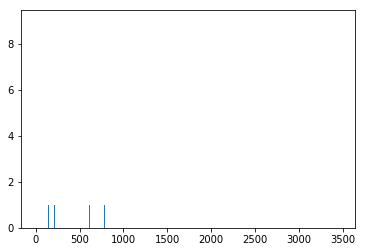

In [247]:
win_prices = df_slot_37389.loc[df_slot_37389['is_winner'] == 1, 'bid_price'].values
hist_win, _ = np.histogram(win_prices, bins=edges)
import matplotlib.pyplot as plt
plt.hist(win_prices, bins=edges)
plt.show()

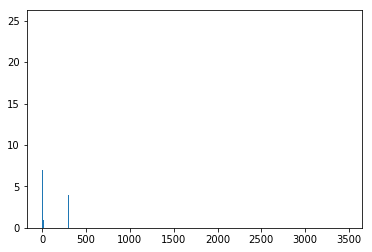

In [249]:
lost_prices = df_slot_37389.loc[df_slot_37389['is_winner'] == 0, 'bid_price'].values
hist_lost, _ = np.histogram(lost_prices, bins=edges)
plt.hist(lost_prices, bins=edges)
plt.show()

In [251]:
(hist_win + hist_lost)

array([25, 10, 16, ...,  0,  0,  1], dtype=int32)

In [258]:
dic_rf_probs, rf_xs_proc, rf_ys_proc, x_width =\
    training_function.calc_rf_probs(rf, real_prices, real_edges)
print('dic_rf_probs: ', dic_rf_probs)
print('rf_xs_proc: ', rf_xs_proc)
print('rf_ys_proc: ', rf_ys_proc)
print('x_width: ', x_width)

dic_rf_probs:  {0: (0.0, 0), 1: (0.0, 0), 2: (0.0, 0), 3: (0.0, 0), 4: (0.0, 0), 5: (0.0, 0), 6: (0.0, 0), 7: (0.0, 0), 8: (0.0, 0), 9: (0.0, 0), 10: (0.0, 0), 11: (0.0, 0), 12: (0.0, 0), 13: (0.0, 0), 14: (0.0, 0), 15: (0.0, 0), 16: (0.0, 0), 17: (0.0, 0), 18: (0.0, 0), 19: (0.0, 0), 20: (0.0, 0), 21: (0.0, 0), 22: (0.0, 0), 23: (0.0, 0), 24: (0.0, 0), 25: (0.0, 0), 26: (0.0, 0), 27: (0.0, 0), 28: (0.0, 0), 29: (0.0, 0), 30: (0.0, 0), 31: (0.0, 0), 32: (0.0, 0), 33: (0.0, 0), 34: (0.0, 0), 35: (0.0, 0), 36: (0.0, 0), 37: (0.0, 0), 38: (0.0, 0), 39: (0.0, 0), 40: (0.0, 0), 41: (0.0, 0), 42: (0.0, 0), 43: (0.0, 0), 44: (0.0, 0), 45: (0.0, 0), 46: (0.0, 0), 47: (0.0, 0), 48: (0.0, 0), 49: (0.0, 0), 50: (0.0, 0), 51: (0.0, 0), 52: (0.0, 0), 53: (0.0, 0), 54: (0.0, 0), 55: (0.0, 0), 56: (0.0, 0), 57: (0.0, 0), 58: (0.2, 0), 59: (0.5, 0), 60: (0.5999999999999999, 0), 61: (0.5999999999999999, 0), 62: (0.6599999999999999, 0), 63: (0.86, 0), 64: (1.0, 0), 65: (1.0, 0), 66: (1.0, 0), 67: (1.0, 

In [262]:
len(real_edges)

3473

In [278]:
real_width = int(real_prices[1]-real_prices[0]) # = x_width
model_width = float(real_width) / 10
model_prices =\
        np.arange(min(real_edges), max(real_edges) + model_width, model_width)
features = model_prices.reshape(-1, 1) # convert to prepare to predict by rf model
probs = rf.predict_proba(features)[:, 1]
print(probs)

[ 0.  0.  0. ...,  1.  1.  1.]


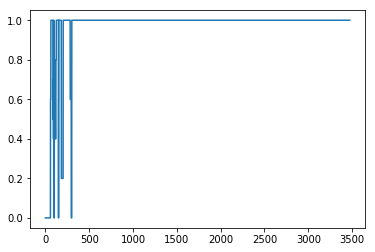

In [287]:
plt.plot(features, probs)
plt.show()

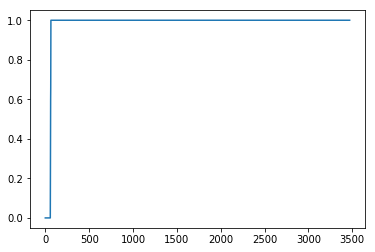

In [291]:
xs_smth, ys_smth = training_function._smoothing(list(model_prices), list(probs), real_edges)
ys_smth_mi = training_function._mono_increase(ys_smth)
plt.plot(xs_smth, ys_smth_mi)
plt.show()

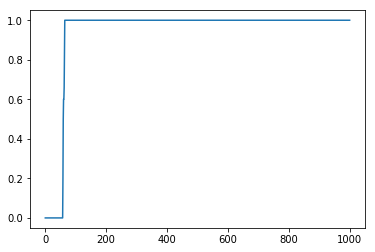

In [293]:
LL_MAX_PRICE = 1000  # yen/mil
MAX_PROB = 0.99

xs_rf_fine, ys_rf_fine = [], []
for i, (x, y) in enumerate(zip(xs_smth, ys_smth_mi)):
    if y <= MAX_PROB or x <= LL_MAX_PRICE:
        xs_rf_fine.append(int(x))
        ys_rf_fine.append(y)
    else:
        i -= 1
        break
assert xs_rf_fine == real_prices[:i + 1]
plt.plot(xs_rf_fine, ys_rf_fine)
plt.show()

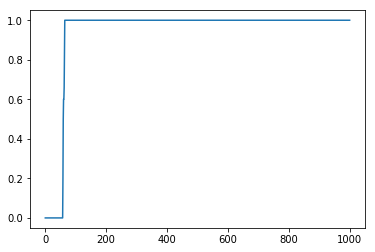

In [294]:
# set prob=0.0 when bid_price=0.0
flag_zero_fill = False
if xs_rf_fine[0] > 0:
    xs_rf_fine.insert(0, 0)
    ys_rf_fine.insert(0, 0.0)
    flag_zero_fill = True
elif (xs_rf_fine[0] == 0) and (ys_rf_fine[0] > 0):
    ys_rf_fine[0] = 0.0
    flag_zero_fill = True
# the second values is "flag_extrapolation".
# this value is difined to be 0 under the RF model preicition.
dic_rf_preds = {x: (y, 0) for x, y in zip(xs_rf_fine, ys_rf_fine)}
# modify flag_extrapolation when needed
if flag_zero_fill:
    dic_rf_preds[0] = (0.0, 1)
plt.plot(xs_rf_fine, ys_rf_fine)
plt.show()

In [300]:
dic_rf_probs = {x: (y, 0) for x,y in zip(xs_rf_fine, ys_rf_fine)}

In [301]:
rf_xs_proc = xs_rf_fine
rf_ys_proc = ys_rf_fine

In [303]:
training_function.calc_func_model(rf_xs_proc, rf_ys_proc, floor_price, x_width)

C:/Users/hoang/PycharmProjects/ReeMo_mini\winning_model\training_function.py:282: RuntimeWarning: divide by zero encountered in true_divide
  vals = (x - b) / ((x - b) + c)


({0: (0.0, 1),
  1: (0.0, 1),
  2: (0.0, 1),
  3: (0.0, 1),
  4: (0.0, 1),
  5: (0.0, 1),
  6: (0.0, 1),
  7: (0.0, 1),
  8: (0.0, 1),
  9: (0.0, 1),
  10: (0.0, 1),
  11: (0.0, 1),
  12: (0.0, 1),
  13: (0.0, 1),
  14: (0.0, 1),
  15: (0.0, 1),
  16: (0.0, 1),
  17: (0.0, 1),
  18: (0.0, 1),
  19: (0.0, 1),
  20: (0.0, 1),
  21: (0.0, 1),
  22: (0.0, 1),
  23: (0.0, 1),
  24: (0.0, 1),
  25: (0.0, 1),
  26: (0.0, 1),
  27: (0.0, 1),
  28: (0.0, 1),
  29: (0.0, 1),
  30: (0.0, 1),
  31: (0.0, 1),
  32: (0.0, 1),
  33: (0.0, 1),
  34: (0.0, 1),
  35: (0.0, 1),
  36: (0.0, 1),
  37: (0.0, 1),
  38: (0.0, 1),
  39: (0.0, 1),
  40: (0.0, 1),
  41: (0.0, 1),
  42: (0.0, 1),
  43: (0.0, 1),
  44: (0.0, 1),
  45: (0.0, 1),
  46: (0.0, 1),
  47: (0.0, 1),
  48: (0.0, 1),
  49: (0.0, 1),
  50: (0.0, 1),
  51: (0.0, 1),
  52: (0.0, 1),
  53: (0.0, 1),
  54: (0.0, 1),
  55: (0.0, 1),
  56: (0.0, 1),
  57: (0.0, 1),
  58: (0.0, 1),
  59: (0.0, 1),
  60: (0.0, 1),
  61: (0.0, 1),
  62: (0.657947524

In [304]:
def func_winning_model(x, b, c):
    vals = (x - b) / ((x - b) + c)
    return np.where(x > b, vals, 0.)

In [305]:
TEMP_MAX_PRICE = 10000  # yen/mil
MAX_PROB = 0.99
INIT_PAR_VAL = 1.0  # empirical value

In [312]:
# https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.optimize.curve_fit.html
from scipy.optimize import curve_fit
popt, pcov = curve_fit(func_winning_model, rf_xs_proc, rf_ys_proc,
                               p0=[floor_price, INIT_PAR_VAL],
                               bounds=([0, 0], [np.inf, np.inf]))
print(popt)
print(pcov)

[ 61.83271476   0.08696792]
[[ 0.00494667 -0.00224882]
 [-0.00224882  0.00115354]]


c:\users\hoang\appdata\local\programs\python\python35-32\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


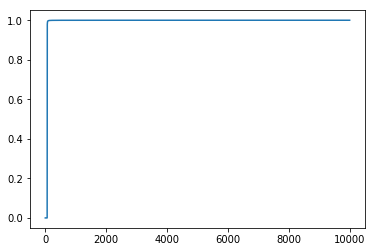

In [319]:
xs = np.arange(0, max(max(rf_xs_proc), TEMP_MAX_PRICE) + x_width, x_width)
ys = func_winning_model(xs, *popt) 
plt.plot(xs, ys) # curve
plt.show() 

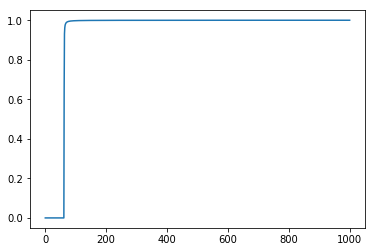

In [322]:
mask = (xs <= max(rf_xs_proc)) | (ys <= MAX_PROB)
func_xs, func_ys = xs[mask], ys[mask]
plt.plot(func_xs, func_ys)
plt.show()

In [325]:
dic_func_probs = {int(x): (float(y), 1) for x, y in zip(func_xs, func_ys)}
popt = [float(v) for v in popt]
dic_func_probs

{0: (0.0, 1),
 1: (0.0, 1),
 2: (0.0, 1),
 3: (0.0, 1),
 4: (0.0, 1),
 5: (0.0, 1),
 6: (0.0, 1),
 7: (0.0, 1),
 8: (0.0, 1),
 9: (0.0, 1),
 10: (0.0, 1),
 11: (0.0, 1),
 12: (0.0, 1),
 13: (0.0, 1),
 14: (0.0, 1),
 15: (0.0, 1),
 16: (0.0, 1),
 17: (0.0, 1),
 18: (0.0, 1),
 19: (0.0, 1),
 20: (0.0, 1),
 21: (0.0, 1),
 22: (0.0, 1),
 23: (0.0, 1),
 24: (0.0, 1),
 25: (0.0, 1),
 26: (0.0, 1),
 27: (0.0, 1),
 28: (0.0, 1),
 29: (0.0, 1),
 30: (0.0, 1),
 31: (0.0, 1),
 32: (0.0, 1),
 33: (0.0, 1),
 34: (0.0, 1),
 35: (0.0, 1),
 36: (0.0, 1),
 37: (0.0, 1),
 38: (0.0, 1),
 39: (0.0, 1),
 40: (0.0, 1),
 41: (0.0, 1),
 42: (0.0, 1),
 43: (0.0, 1),
 44: (0.0, 1),
 45: (0.0, 1),
 46: (0.0, 1),
 47: (0.0, 1),
 48: (0.0, 1),
 49: (0.0, 1),
 50: (0.0, 1),
 51: (0.0, 1),
 52: (0.0, 1),
 53: (0.0, 1),
 54: (0.0, 1),
 55: (0.0, 1),
 56: (0.0, 1),
 57: (0.0, 1),
 58: (0.0, 1),
 59: (0.0, 1),
 60: (0.0, 1),
 61: (0.0, 1),
 62: (0.6579475249595461, 1),
 63: (0.9306615876207569, 1),
 64: (0.961420516382

In [326]:
dic_winning_model = {}
dic_winning_model.update(dic_func_probs)
dic_winning_model.update(dic_rf_probs)   


{0: (0.0, 0),
 1: (0.0, 0),
 2: (0.0, 0),
 3: (0.0, 0),
 4: (0.0, 0),
 5: (0.0, 0),
 6: (0.0, 0),
 7: (0.0, 0),
 8: (0.0, 0),
 9: (0.0, 0),
 10: (0.0, 0),
 11: (0.0, 0),
 12: (0.0, 0),
 13: (0.0, 0),
 14: (0.0, 0),
 15: (0.0, 0),
 16: (0.0, 0),
 17: (0.0, 0),
 18: (0.0, 0),
 19: (0.0, 0),
 20: (0.0, 0),
 21: (0.0, 0),
 22: (0.0, 0),
 23: (0.0, 0),
 24: (0.0, 0),
 25: (0.0, 0),
 26: (0.0, 0),
 27: (0.0, 0),
 28: (0.0, 0),
 29: (0.0, 0),
 30: (0.0, 0),
 31: (0.0, 0),
 32: (0.0, 0),
 33: (0.0, 0),
 34: (0.0, 0),
 35: (0.0, 0),
 36: (0.0, 0),
 37: (0.0, 0),
 38: (0.0, 0),
 39: (0.0, 0),
 40: (0.0, 0),
 41: (0.0, 0),
 42: (0.0, 0),
 43: (0.0, 0),
 44: (0.0, 0),
 45: (0.0, 0),
 46: (0.0, 0),
 47: (0.0, 0),
 48: (0.0, 0),
 49: (0.0, 0),
 50: (0.0, 0),
 51: (0.0, 0),
 52: (0.0, 0),
 53: (0.0, 0),
 54: (0.0, 0),
 55: (0.0, 0),
 56: (0.0, 0),
 57: (0.0, 0),
 58: (0.2, 0),
 59: (0.5, 0),
 60: (0.5999999999999999, 0),
 61: (0.5999999999999999, 0),
 62: (0.6599999999999999, 0),
 63: (0.86, 0),
 64:

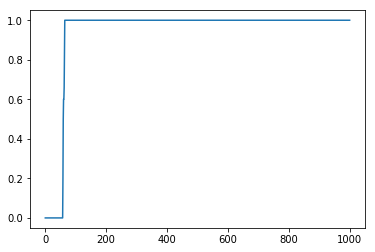

In [354]:
prices_probs = [[price, prob[0]] for price, prob in dic_winning_model.items()]
prices_probs = np.array(prices_probs).T
prices, probs = prices_probs[0], prices_probs[1]
plt.plot(prices, probs)
plt.show()

In [407]:
def plot_winning_model(dic_winning_model):
    prices_probs = [[price, prob[0]] for price, prob in sorted(dic_winning_model.items())]
    prices_probs = np.array(prices_probs).T
    prices, probs = prices_probs[0], prices_probs[1]
    plt.plot(prices, probs, linestyle=':', color='blue')
    plt.show()

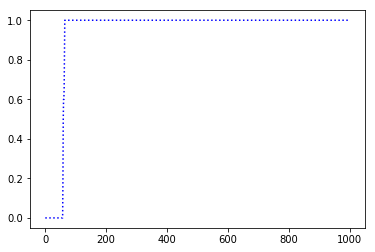

In [408]:
plot_winning_model(dic_rf_probs)

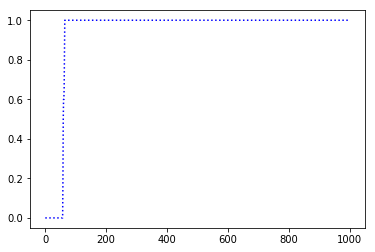

In [409]:
dic_winning_model_reduced = training_function.reduce_wm_size(dic_winning_model)
plot_winning_model(dic_winning_model_reduced)

In [410]:
EPS = 1e-3  # 0.1%
ys = np.asarray(list(dic_winning_model_reduced.values()))[:, 0]
ylow, yhig = ys.min() + EPS, ys.max() - EPS
ylow, yhig

(0.001, 0.999)

{64: (1.0, 0), 57: (0.0, 0), 58: (0.2, 0), 59: (0.5, 0), 60: (0.6, 0), 61: (0.6, 0), 62: (0.66, 0), 63: (0.86, 0)}


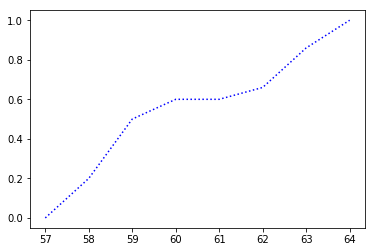

In [411]:
dic_winning_model_reduced_truncated = \
    training_function.truncate_wm(dic_winning_model_reduced)
print(dic_winning_model_reduced_truncated)
plot_winning_model(dic_winning_model_reduced_truncated)